In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.model_selection import train_test_split, StratifiedKFold
from utils_window import TimeSeriesScaler, f1_m, MIMIC_DATA_PATH


from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, matthews_corrcoef
# from util import heat_map, xai_eval_fnc

2023-03-18 18:30:25.296239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 18:30:29.743683: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-18 18:30:35.157166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-18 18:30:35.157279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
import numpy as np
import math
from copy import deepcopy

def xai_eval_fnc(model, relevence, input_x, model_type='lstm', percentile=90,
                 eval_type='prtb', seq_len=10, by='all'):
    """
    Evaluates the quality metrics of time-series importance scores using various evaluation methods.

    Parameters
    ----------
    model : prediction model that is explained 
    relevance : A 3D array of importance scores for each time step of the time-series data
    input_x : input data of the prediction model. If the input data consists of different modalities, the first module should be a 3D time series data
    model_type (optional) : type of model, either 'lstm' or 'lstm_plus'. Use 'lstm' when the time series data is the only modality of the input, otherwise use 'lstm_plus'
    percentile (optional) : percentile of top time steps that are going to be pertubed
    eval_type (optional) : evaluation method, either 'prtb' for the perturbation analysis metric or 'sqnc' for sequence analysis metric
    seq_len (optional) : sequence length for 'sqnc' method
    by (optional) : whether to evaluate each temporal feature separately or all time steps together, either 'time' or 'all'

    Returns : prediction of the modified input time-series data using the input model
    """
    
    input_new = deepcopy(input_x)
    relevence = np.absolute(relevence)
    
    # TO DO: Add other type of models
    if model_type == 'lstm_plus':
        input_ts = input_x[0]
        input_new_ts = input_new[0]
    elif model_type == 'lstm':
        input_ts = input_x
        input_new_ts = input_new
    
    assert len(input_ts.shape)==3 # the time sereis data needs to be 3-dimensional
    num_feature = input_ts.shape[2]
    num_time_step = input_ts.shape[1]
    num_instance = input_ts.shape[0]
        
    if by=='time':
        top_steps = math.ceil((1 - percentile/100) * num_time_step) # finding the number of top steps for each feature
        top_indices = np.argsort(relevence, axis=1)[:, -top_steps:, :] # a 3d array of top time steps for each feature
        for j in range(num_feature): # converting the indices to a flatten version
            top_indices[:, :, j] = top_indices[:, :, j] * num_feature + j
        top_indices = top_indices.flatten()
    elif by=='all':
        top_steps = math.ceil((1 - percentile/100) * num_time_step * num_feature) # finding the number of all top steps
        top_indices = np.argsort(relevence, axis=None)[-top_steps:]
    # print(top_indices)
    
    # Create a masking matrix for top time steps
    top_indices_mask = np.zeros(input_ts.size)
    top_indices_mask[top_indices] = 1
    top_indices_mask = top_indices_mask.reshape(input_ts.shape)
    
    
    # Evaluating different metrics
    for p in range(num_instance):
        for v in range(num_feature):
            for t in range(num_time_step):
                if top_indices_mask[p, t, v]:
                    if eval_type == 'prtb':
                        input_new_ts[p,t,v] = np.max(input_ts[p,:,v]) - input_ts[p,t,v]
                        # input_new_ts[p,t,v] = 0 ### possible edit here
                    elif eval_type == 'sqnc':
                        input_new_ts[p, t:t + seq_len, v] = 0
    
    return model.predict(input_new)


def heat_map(start, stop, x, shap_values, var_name='Feature 1', plot_type='bar', title=None, val_type='wSHAP values'):
    """
    A function that generates a heatmap with the temporal sequence alongside its Shapley values

    Parameters
    ----------
    start (int): the starting point of the temporal sequence
    stop (int): the ending point of the temporal sequence
    x (np.ndarray): the sequence data
    shap_values (np.ndarray): the Shapley values corresponding to the sequence data
    var_name (str): the name of the variable being plotted (default: 'Feature 1')
    plot_type (str): the type of plot to generate ('bar' or 'heat' or 'heat_abs', default: 'bar')
    title (str): the title for the plot (default: None)
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import BoundaryNorm
    from textwrap import wrap
    import numpy as np; np.random.seed(1)
    
    ## ColorMap-------------------------
    # define the colormap
    cmap = plt.get_cmap('PuOr_r')

    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize and forcing 0 to be part of the colorbar!
    bounds = np.arange(np.min(shap_values),np.max(shap_values),.5)
    idx=np.searchsorted(bounds,0)
    bounds=np.insert(bounds,idx,0)
    norm = BoundaryNorm(bounds, cmap.N)
    # print(bounds)
    ##------------------------------------
    
    if title is None: title = '\n'.join(wrap('{} values and contribution scores'.format(var_name), width=40))
    
    if plot_type=='heat' or plot_type=='heat_abs':
        plt.rcParams["figure.figsize"] = 9,3
        if plot_type=='heat_abs':
            shap_values = np.absolute(shap_values)
            cmap = 'Reds'
        fig, ax1 = plt.subplots(sharex=True)
        extent = [start, stop, -2, 2]
        im1 = ax1.imshow(shap_values[np.newaxis, :], cmap=cmap, norm=norm, aspect="auto", extent=extent)
        ax1.set_yticks([])
        ax1.set_xlim(extent[0], extent[1])
        ax1.title.set_text(title)
        fig.colorbar(im1, ax=ax1, pad=0.1)
        ax2 = ax1.twinx()
        ax2.plot(np.arange(start, stop), x, color='black')
    elif plot_type=='bar':
        plt.rcParams["figure.figsize"] = 8.5,2.5
        fig, ax1 = plt.subplots(sharex=True)
        mask1 = shap_values < 0
        mask2 = shap_values >= 0
        ax1.bar(np.arange(start, stop)[mask1], shap_values[mask1], color='blue', label='Negative Shapley values')
        ax1.bar(np.arange(start, stop)[mask2], shap_values[mask2], color='red', label='Positive Shapley values')
        ax1.set_title(title)
        ax2 = ax1.twinx()
        ax2.plot(np.arange(start, stop), x, 'k-', label='Observed data')
        # legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        # ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    ax1.set_xlabel('Time steps')
    if plot_type=='bar': ax1.set_ylabel(val_type)
    ax2.set_ylabel(var_name + ' data values')
    plt.tight_layout()
    plt.show()

In [3]:
##### load data and reformat
data = np.load('mimic3_all.npz')

data_x, data_y = data['arr_0'], data['arr_1']

data_y = data_y.reshape(-1,1)

In [4]:
# Splitting data
train_x, test_x, train_y, test_y= train_test_split(data_x, data_y,test_size=0.05, random_state=1, stratify=data_y)

In [5]:
# normalizing train and test set
train_scaler, test_scaler = TimeSeriesScaler(), TimeSeriesScaler()
train_x = train_scaler.fit_transform(train_x)
test_x = test_scaler.fit_transform(test_x)
                                   

In [6]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((21838, 48, 26), (1150, 48, 26), (21838, 1), (1150, 1))

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

In [8]:
####
import tensorflow.keras.backend as K
def clear_sess():
  try:
    del model 
    del history 
  except:
    pass
  # from tensorflow.keras import backend as K
  K.clear_session()
  import gc
  gc.collect()



  return None
clear_sess()

In [9]:
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#     # Normalization and Attention
#     x = layers.LayerNormalization(epsilon=1e-6)(inputs)
#     x, weights = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout, 
#                                            attention_axes=(1)
#                                           )(x, x, return_attention_scores=True)
#     x = layers.Dropout(dropout)(x)
#     res = x + inputs

#     # Feed Forward Part
#     x = layers.LayerNormalization(epsilon=1e-6)(res)
#     # x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="gelu")(x)
#     # x = layers.Dropout(dropout)(x)
#     # x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#     return x + res

In [10]:
# def build_model(input_shape,head_size, num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0, mlp_dropout=0):
#     inputs = keras.Input(shape=input_shape)
#     x = inputs
#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#     x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
#     for dim in mlp_units:
#         x = layers.Dense(dim, activation="gelu")(x)
#         x = layers.Dropout(mlp_dropout)(x)
#     outputs = layers.Dense(1, activation="sigmoid")(x)
#     return keras.Model(inputs, outputs)

In [11]:
# model = build_model((48, 26),head_size=32,num_heads=26,ff_dim=4,num_transformer_blocks=1,mlp_units=[32],mlp_dropout=0.4,dropout=0.25)

2023-03-10 17:47:47.249354: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-03-10 17:47:47.249377: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Legion5
2023-03-10 17:47:47.249381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Legion5
2023-03-10 17:47:47.249496: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.12
2023-03-10 17:47:47.249511: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.12
2023-03-10 17:47:47.249515: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.85.12
2023-03-10 17:47:47.249850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

In [ ]:
# model.summary()

In [13]:
# def keras_mcc(y_true, y_pred):
#     tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
#     fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
#     fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

#     num = tp * tn - fp * fn
#     den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
#     return num / K.sqrt(den + K.epsilon())

In [14]:
# metrics_c = [keras.metrics.AUC(name="auc_roc",curve="ROC"),keras.metrics.AUC(name="auc_pr",curve="PR"),keras_mcc]

In [15]:
# from datetime import datetime

# now = datetime.now() 

In [16]:
# callbacks = [keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True),]
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95,patience=50, min_lr=0.0001, verbose=1)

# checkpoint_filepath_4 = f'weights-improvement-val-keras-mcc-{now}.hdf5'
# model_checkpoint_callback_4 = ModelCheckpoint(filepath=checkpoint_filepath_4,save_weights_only=False,monitor='val_keras_mcc',mode='max',save_best_only=True)

In [17]:
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=metrics_c, weighted_metrics=[])

In [13]:
# model.summary()

In [ ]:
# train_history=model.fit(train_x,train_y,
#                         validation_data=(test_x,test_y), epochs=50,
#                         verbose=1,
#                         batch_size=128,callbacks=[reduce_lr, model_checkpoint_callback_4])

In [9]:
# # model.save('mimic3_MHAT_transformer_march10.hdf5')
# #### load model

# # model = keras.models.load_model('mimic3_ts_transformer_4march_wattscores_48x26x26.h5_best.hdf5', compile=False)
# model = keras.models.load_model('good_models/weights-improvement-new-model-5percent-test.hdf5', compile=False) # better model


# ## define model loss to be used later
keras_loss = keras.losses.BinaryCrossentropy(from_logits=True)
model = keras.models.load_model('good_models/weights-improvement-val-keras-mcc-2023-03-10 17_51_00.683286.hdf5', compile=False)

2023-03-18 18:31:14.282952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 18:31:15.136376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 18:31:15.136571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 18:31:15.147631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
def ab_scaler(data,a,b):
    sdata = (b-a)*((data - np.min(data))/(np.max(data) - np.min(data))) + a
    return sdata

In [11]:
y_train_pred = model.predict(train_x, verbose=0)
print(roc_auc_score(train_y, y_train_pred))
print(average_precision_score(train_y, y_train_pred))
print(f1_score(train_y, np.round(y_train_pred)))
print(recall_score(train_y, np.round(y_train_pred)))
print(precision_score(train_y, np.round(y_train_pred)))
print(matthews_corrcoef(train_y, np.round(y_train_pred)))
# print('Model Loss: ',"{:.4f}".format(keras_loss(train_y, model.predict(train_x, verbose=0)).numpy()))

0.9460715703278403
0.8083525570235089
0.7019830028328612
0.5696551724137932
0.9143911439114392
0.6998082983525663


In [12]:
y_test_pred = model.predict(test_x, verbose=0)
print(roc_auc_score(test_y,y_test_pred ))
print(average_precision_score(test_y,y_test_pred ))
print(f1_score(test_y, np.round(y_test_pred)))
print(recall_score(test_y, np.round(y_test_pred)))
print(precision_score(test_y, np.round(y_test_pred)))
print(matthews_corrcoef(test_y, np.round(y_test_pred)))
# print('Model Loss: ',"{:.4f}".format(keras_loss(test_y, model.predict(test_x, verbose=0)).numpy()))

0.72392354547364
0.24003325459634156
0.29545454545454547
0.22608695652173913
0.4262295081967213
0.25736706168329593


In [13]:
#### for multi_head_attention 
att_layerout_MHA0= keras.Model(inputs=model.input, outputs=model.get_layer('multi_head_attention').output)

# att_layerout_MHA0= keras.Model(inputs=model.input, outputs=model.get_layer('multi_head_attention_1').output)

In [14]:
att_output_MHA0 = att_layerout_MHA0.predict(test_x, verbose=0)

In [15]:
att_outvals_MHA0, att_scores_MHA0 = att_output_MHA0
print(att_outvals_MHA0.shape, att_scores_MHA0.shape)

(1150, 48, 26) (1150, 26, 48, 48)


In [16]:
#### normalize then swap axes
temp_att_scores_dim2 = np.mean(att_scores_MHA0,axis=2)
temp_att_scores_dim3 = np.mean(att_scores_MHA0,axis=3)

In [17]:
temp_att_scores_dim2 = np.transpose(temp_att_scores_dim2, axes=(0,2,1))
temp_att_scores_dim3 = np.transpose(temp_att_scores_dim3, axes=(0,2,1))

In [18]:
# temp_att_scores_dim2 = np.mean(att_scores_MHA0,axis=2) ###the right way
# temp_att_scores_dim3 = np.mean(att_scores_MHA0,axis=3) ###
print(att_outvals_MHA0.shape, temp_att_scores_dim2.shape)

(1150, 48, 26) (1150, 48, 26)


In [19]:
# sc_att_scores = att_outvals_MHA0
sc_att_scores = temp_att_scores_dim2
# sc_att_scores = ab_scaler(sc_att_scores, 0, 1)

xai_MHA_prtb_tsphi = xai_eval_fnc(model, sc_att_scores, test_x, eval_type='prtb',
                                  by='all',
                                  percentile=25
                                 ) #MH attention
# xai_MHA_prtb_tsphi = xai_eval_fnc(model, temp_att_scores_dim2, test_x, eval_type='prtb') #MH attention


##### sequence based on attention
seq_len_val  = 6
xai_MHA_sqnc_tsphi = xai_eval_fnc(model, sc_att_scores, test_x, eval_type='sqnc',seq_len=seq_len_val,
                                  by='all',
                                  percentile=25
                                 ) #MH attention

# xai_MHA_sqnc_tsphi = xai_eval_fnc(model, temp_att_scores_dim2, test_x, eval_type='sqnc',seq_len=seq_le/n_val) #MH attention


test_y_n = test_y

36/36 [==============================] - 1s 18ms/step


In [20]:
# y_pred_orig=y_test_pred
# print('Original Model Predictions: ')
# print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, y_pred_orig)))
# print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, y_pred_orig)))
# print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(y_pred_orig > 0.5, 1, 0))))
# print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
# print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
# print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
# print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, y_pred_orig).numpy()))
# print('')

###### Multihead attention - prtb ALL
print('Multihead Attention Perturbation Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_MHA_prtb_tsphi)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_MHA_prtb_tsphi)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_MHA_prtb_tsphi  > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_MHA_prtb_tsphi > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_MHA_prtb_tsphi ).numpy()))
print('')

###### Multihead attention - sqnc ALL
print(f'Multihead Attention Sequence {seq_len_val} Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_MHA_sqnc_tsphi)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_MHA_sqnc_tsphi)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_MHA_sqnc_tsphi  > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_MHA_sqnc_tsphi > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_MHA_sqnc_tsphi ).numpy()))
print('')

Multihead Attention Perturbation Analysis Predictions: 
AUC ROC   :  0.7244
AUC PR    :  0.2442
F1 Score  :  0.2775
Recall    :  0.2087
Precision :  0.4138
MCC       :  0.2411
Model Loss:  0.7210

Multihead Attention Sequence 6 Analysis Predictions: 
AUC ROC   :  0.7280
AUC PR    :  0.2451
F1 Score  :  0.2793
Recall    :  0.2174
Precision :  0.3906
MCC       :  0.2352
Model Loss:  0.7215



In [27]:
# visualization of attention scores
feature_map_mimic_26 = ['ANION GAP', 'ALBUMIN', 'BICARBONATE', 'BILIRUBIN','CREATININE', 'CHLORIDE', 'GLUCOSE', 'HEMATOCRIT', 
                     'LACTATE', 'MAGNESIUM', 'PHOSPHATE','PLATELET', 'POTASSIUM', 'PTT','INR', 'PT', 
                     'SODIUM', 'BUN', 'WBC', 'HeartRate', 'SysBP', 'DiasBP', 'MeanBP', 'RespRate', 'SpO2','Temp']

In [19]:
#nw_24

# ts_phi_3_0001_0575 = np.load('better_model_wshap/new_hpc/mhat_ts_phi_3_alltest1150_d0p01_nw24_0001_0575.npy') #p0001-p0575
# ts_phi_3_0576_1065 = np.load('better_model_wshap/new_hpc/mhat_ts_phi_3_alltest1150_d0p01_nw24_0576_1065.npy') #p576-p1065
# ts_phi_3_1066_1150 = np.load('better_model_wshap/new_hpc/mhat_ts_phi_3_alltest1150_d0p01_nw24_1066_1150.npy') #p1066-p1150


#nw_12

# ts_phi_3_0001_0575 = np.load('better_model_wshap/new_hpc/mhat_ts_phi_3_alltest1150_d0p01_nw12_0001_0575.npy') #p0001-p0575
# ts_phi_3_0576_1065 = np.load('better_model_wshap/new_hpc/mhat_ts_phi_3_alltest1150_d0p01_nw12_0576_1065.npy') #p576-p1065
# ts_phi_3_1066_1150 = np.load('better_model_wshap/new_hpc/mhat_ts_phi_3_alltest1150_d0p01_nw12_1066_1150.npy') #p1066-p1150





# ts_phi_3 = np.load('better_model_wshap/new_hpc/mhat_ts_phi_3_alltest1150_d0p01_nw12_0001_1150.npy')
ts_phi_3 = np.load('better_model_wshap/new_hpc/mhat_ts_phi_3_alltest1150_d0p01_nw24_0001_1150.npy')

In [20]:
# ts_phi_3 = np.concatenate((ts_phi_3_0001_0575,ts_phi_3_0576_1065,ts_phi_3_1066_1150))

In [21]:
ts_phi_3.shape

(1150, 48, 26)

In [22]:
# np.save('better_model_wshap/new_hpc/mhat_ts_phi_3_alltest1150_d0p01_nw12_0001_1150.npy',ts_phi_3)

In [23]:
################### visualization wSHAP vs attention
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
num_test = 0 #till 1150 
var = 18        #### feature index
phi_index = 0   #### patient index


# pos_indexes  2,   12,   28,   36,   50,   68,   77,   80,   82,  116,  119,
#          131,  136,  154,  187,  203,  206,  209,  221,  236,  244,  263,
#          307,  311,  315,  320,  338,  355,  367,  371,  375,  376,  378,
#          381,  390,  392,  409,  453,  455,  456,  504,  514,  525,  545,
#          553,  557,  562,  568,  570,  590,  596,  

Text(0.5, 1.0, 'Scaled Attention Scores')

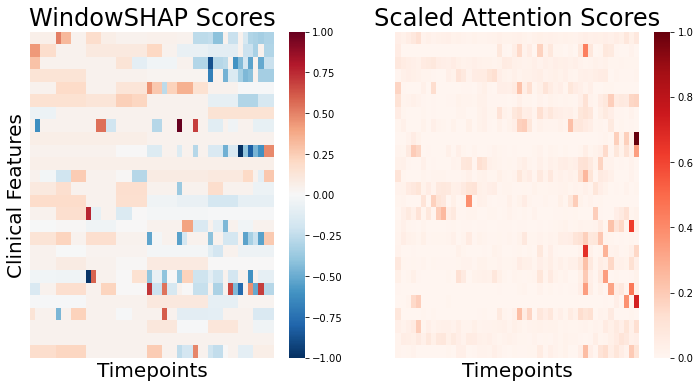

In [72]:
# fig, axes = plt.subplots(3, 2, figsize=(25, 12))
# phi_index_hm = 2
# ax1 = sns.heatmap(ab_scaler(test_x[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[0,0],)
# axes[0,0].title.set_text('Original data')

# sns.heatmap(ab_scaler(ts_phi_1[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[0,1],)
# axes[0,1].title.set_text('Stationary SHAP')

# sns.heatmap(ab_scaler(ts_phi_2[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[1,0],)
# axes[1,0].title.set_text('Sliding SHAP')

# sns.heatmap(ab_scaler(ts_phi_3[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[1,1],)
# axes[1,1].title.set_text('Dynamic SHAP')

# sns.heatmap(ab_scaler(temp_att_scores_dim2[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[2,0],)
# axes[2,0].title.set_text('Attention Score Type 1')

# sns.heatmap(ab_scaler(temp_att_scores_dim3[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[2,1],)
# axes[2,1].title.set_text('Attention Score Type 2')

# # ax1.tick_params(axis='both', which='both', length=0)
# # axes[0,0].title.set_text('First Plot')
# plt.show()


#################################### comparing wSHAP vs Attention
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(1, 2, figsize=(12, 6),sharey=True)
# gs1 = gridspec.GridSpec(1, 2)
# gs1.update(wspace=0.001) # set the spacing between axes. 

phi_index_hm = 2 #2
# ax1 = sns.heatmap(ab_scaler(test_x[num_test + phi_index_hm, :, :].T,0,1), cmap="BuPu",ax=axes[0,0],)
# axes[0,0].title.set_text('Original data')

pat_ts_phi_3 = ts_phi_3[num_test + phi_index_hm, :, :].T
# sns.heatmap(ab_scaler(ts_phi_3[num_test + phi_index_hm, :, :].T,-1,1),ax=axes[0], cmap="RdBu_r")
sns.heatmap(ab_scaler(ts_phi_3[num_test + phi_index_hm, :, :].T,-1,1),ax=axes[0], cmap="RdBu_r",center=0)
# sns.heatmap(pat_ts_phi_3, cmap="RdBu_r",ax=axes[0], vmin=np.min(pat_ts_phi_3),vmax=np.max(pat_ts_phi_3), center=0)
# axes[0].title.set_text('Dynamic WindowSHAP Scores')
# axes[0].set_xticks(range(1,49))
axes[0].set_xlabel('Timepoints', fontsize=20)
axes[0].set_ylabel('Clinical Features', fontsize=20)
# axes[0].set_xticklabels(range(1,49), rotation=60)
axes[0].set_yticks(range(1,27))
# axes[0].set_yticklabels(feature_map_mimic_26, rotation=0)
axes[0].set_yticklabels([])
# axes[0].set_title('Dynamic WindowSHAP Scores', fontdict={'fontsize': 24, 'fontweight': 'medium'})
axes[0].set_title('WindowSHAP Scores', fontdict={'fontsize': 24, 'fontweight': 'medium'})
axes[0].set_xticks([])

# sns.heatmap(ab_scaler(temp_att_scores_dim2[num_test + phi_index_hm, :, :].T,np.min(pat_ts_phi_3),np.max(pat_ts_phi_3)), cmap="BuPu",ax=axes[1,0],)
# axes[1,0].title.set_text('Attention Score Type 1')

# sns.heatmap(ab_scaler(temp_att_scores_dim3[num_test + phi_index_hm, :, :].T,np.min(pat_ts_phi_3),np.max(pat_ts_phi_3)), cmap="RdBu_r",ax=axes[1], vmin=np.min(pat_ts_phi_3),vmax=np.max(pat_ts_phi_3), center=0)
sns.heatmap(ab_scaler(temp_att_scores_dim2[num_test + phi_index_hm, :, :].T,0,1), 
            # cmap="Reds",
            cmap = sns.color_palette("Reds", as_cmap=True),
            ax=axes[1], 
            vmin=0,
            vmax=1, 
            # center=0,
           )

# sns.heatmap(temp_att_scores_dim3[num_test + phi_index_hm, :, :].T, cmap="Reds",ax=axes[1])
# axes[1].title.set_text('Scaled Attention Scores')
# axes[1].set_xticks(range(1,49))
# axes[1].set_xticklabels(range(1,49), rotation=60)
# axes[1].set_yticks(range(1,27))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('Timepoints', fontsize=20)
# axes[1].set_ylabel('Clinical Features', fontsize=20)
# axes[1].set_yticklabels(feature_map_mimic_26, rotation=0)
axes[1].set_title('Scaled Attention Scores', fontdict={'fontsize': 24, 'fontweight': 'medium'})

# plt.show()
# plt.savefig('AMIA_poster_submission_fig2_scores.png', dpi=600, bbox_inches='tight')

In [39]:
# fig, axes = plt.subplots(2, 2, figsize=(25, 12))
# phi_index_hm = 16
# ax1 = sns.heatmap(ab_scaler(test_x[num_test + phi_index_hm, :, :].T,-1,1), cmap="BuPu",ax=axes[0,0],)
# axes[0,0].title.set_text('Original data')

# sns.heatmap(ab_scaler(ts_phi_3[num_test + phi_index_hm, :, :].T,-1,1), cmap="BuPu",ax=axes[0,1],)
# axes[0,1].title.set_text('Dynamic WindowSHAP Scores')

# sns.heatmap(ab_scaler(temp_att_scores_dim2[num_test + phi_index_hm, :, :].T,-1,1), cmap="BuPu",ax=axes[1,0],)
# axes[1,0].title.set_text('Attention Scores')

# sns.heatmap(ab_scaler(temp_att_scores_dim3[num_test + phi_index_hm, :, :].T,-1,1), cmap="BuPu",ax=axes[1,1],)
# axes[1,1].title.set_text('Attention Scores')

# plt.show()

In [40]:
######### Dip in model metrics
y_pred_orig = model.predict(test_x)
# y_pred_orig


#### get original values of test set predictions
test_y_n = test_y
#### original predictions

print('Original Model Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, y_pred_orig)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, y_pred_orig)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(y_pred_orig > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(y_pred_orig > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, y_pred_orig).numpy()))


36/36 [==============================] - 1s 18ms/step
Original Model Predictions: 
AUC ROC   :  0.7239
AUC PR    :  0.2400
F1 Score  :  0.2955
Recall    :  0.2261
Precision :  0.4262
MCC       :  0.2574
Model Loss:  0.7207


In [59]:
##### perturbations based on Dynamic wSHAP

xai_wSHAP_prtb_tsphi3 = xai_eval_fnc(model, ts_phi_3, test_x, eval_type='prtb',
                                     by='all',
                                     percentile=95) #dynamic

#### sequence analysis on Dynamic wSHAP
seq_len_val  = 12
xai_wSHAP_sqnc_tsphi3 = xai_eval_fnc(model, ts_phi_3, test_x, eval_type='sqnc',seq_len=seq_len_val,
                                     by='all',
                                     percentile=95) #dynamic

36/36 [==============================] - 1s 18ms/step


In [60]:
import warnings
warnings.filterwarnings('ignore')
############# dynamic
print('Dynamic wSHAP Perturbation Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_wSHAP_prtb_tsphi3)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_wSHAP_prtb_tsphi3)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_wSHAP_prtb_tsphi3 > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_wSHAP_prtb_tsphi3 > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_wSHAP_prtb_tsphi3 > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_wSHAP_prtb_tsphi3 > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_wSHAP_prtb_tsphi3).numpy()))
print('')

###### dynamic
print(f'Dynamic wSHAP Sequence {seq_len_val} Analysis Predictions: ')
print('AUC ROC   : ',"{:.4f}".format(roc_auc_score(test_y_n, xai_wSHAP_sqnc_tsphi3)))
print('AUC PR    : ',"{:.4f}".format(average_precision_score(test_y_n, xai_wSHAP_sqnc_tsphi3)))
print('F1 Score  : ',"{:.4f}".format(f1_score(test_y_n, np.where(xai_wSHAP_sqnc_tsphi3 > 0.5, 1, 0))))
print('Recall    : ',"{:.4f}".format(recall_score(test_y_n,np.where(xai_wSHAP_sqnc_tsphi3 > 0.5, 1, 0))))
print('Precision : ',"{:.4f}".format(precision_score(test_y_n,np.where(xai_wSHAP_sqnc_tsphi3 > 0.5, 1, 0))))
print('MCC       : ',"{:.4f}".format(matthews_corrcoef(test_y_n,np.where(xai_wSHAP_sqnc_tsphi3 > 0.5, 1, 0))))
print('Model Loss: ',"{:.4f}".format(keras_loss(test_y_n, xai_wSHAP_sqnc_tsphi3).numpy()))
print('')

Dynamic wSHAP Perturbation Analysis Predictions: 
AUC ROC   :  0.7210
AUC PR    :  0.2326
F1 Score  :  0.2674
Recall    :  0.2000
Precision :  0.4035
MCC       :  0.2310
Model Loss:  0.7212

Dynamic wSHAP Sequence 12 Analysis Predictions: 
AUC ROC   :  0.7125
AUC PR    :  0.2224
F1 Score  :  0.2599
Recall    :  0.2000
Precision :  0.3710
MCC       :  0.2156
Model Loss:  0.7229



In [ ]:
# num_test = 0 #till 1150 
var = 18      #### feature index
phi_index = 31   #### patient index

# good pais 18-2, 18-22, 18-25, 18-27, 18-29, 18-31

wshap_feat3 = ts_phi_3[num_test + phi_index, :, var]

# wshap_feat3.shape

In [299]:
# # Plotting later
# att_feat = temp_att_scores_dim2[num_test + phi_index, :, var]
# att_feat = ab_scaler(att_feat,np.min(wshap_feat3),np.max(wshap_feat3))
# heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=att_feat, var_name=feature_map_mimic_26[var], plot_type='bar', val_type='Attention Scores T 1')

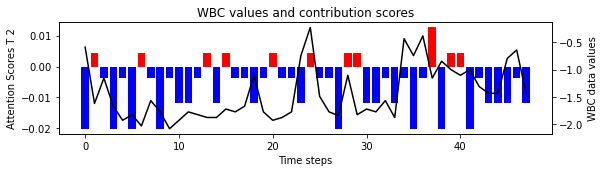

In [300]:
# Plotting later
att_feat = temp_att_scores_dim3[num_test + phi_index, :, var]
att_feat = ab_scaler(att_feat,np.min(wshap_feat3),np.max(wshap_feat3))
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=att_feat, var_name=feature_map_mimic_26[var], plot_type='bar', val_type='Attention Scores T 2')

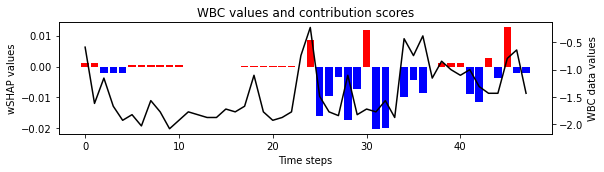

In [301]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=ts_phi_3[num_test + phi_index, :, var], var_name=feature_map_mimic_26[var], plot_type='bar')